# "Ecosystem data for selected disturbed lakes in permafrost regions" 
Cryosphere Virtual Lab, Clemens von Baeckmann, Copyright (c) 2022/2023.

This notebook generates a georeferenced dataset for disturbed areas with focus on lake area change in permafrost regions. The generated data aims to advance the understanding of a changing cryosphere and the corresponding change of ecosystems derived with the edited landcover dataset. This project combine and edit multi-source data sets, implementing the novel CVL environment.

The landcover dataset from Bartsch et al. (2019) available at the CVL Data search, serves as foundation, focusing on selected lakes. Auxiliary data will be added and in the final step the data will be prepared for the use in the CVL3D Viewer of the cryosphere virtual laboratory webpage.


<em>Lets start!</em>

________________________

### Load the data:
---

- first import the python modules:

In [2]:
import os
import sys
import copy
import zipfile
import pygrib
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio import mask as msk 
#from matplotlib import pyplot as plt  
import matplotlib.pyplot as plt
from osgeo import gdal, ogr
import geopandas as gpd
from IPython.display import Image

print('done')

done


- now <b>define</b> if data needs to be downloaded or is already stored locally:

In [4]:
download_data = False #insert False or True if you need to download the data
need_to_download_era5 = False # do you want additional era5data? and need to download era5  data? False or True

buffer_dist = 30 #buffer dist (CVL proposal 30 meter)
buffer_dist_era5 = 10000 #define era5 buffer dist around the lake, check era5 data grid to have input data!)

#trend data: (...found via the CVL Metadata Search)
Lakes_url = 'https://hs.pangaea.de/sat/NitzeI-etal_2018/Lakes_T1.zip'
#landcover data: (...additional data)
Landcover_url = 'https://hs.pangaea.de/sat/GlobPermafrost_Sentinel/Landcover/ZAM_LCP_LANDC_SEN12_V02_20150815_20180830_T01.tif'

if os.path.exists('data') == False:
    os.makedirs('data')
    
print('done')

done


- load the available data:

In [3]:
# download & read data
print('please wait...')

if download_data == True:
    print('___loading Landcover')
    
    if os.path.exists('data/ds_landcover.tif') == False:
        download_string = 'wget -O data/ds_landcover.tif {}'.format(Landcover_url)
        os.system(download_string)
    ds_landcover =  rio.open(Landcover_url)

    print('___loading Trends')
    if os.path.exists('data/Lakes_T1/T1_WS_Lakes.shp') == False:
        print ('downloading and open dataset trend-Lakes')
        download_string = 'wget -O data/Lakes_T1.zip {}'.format(Lakes_url) 
        os.system(download_string)
        with zipfile.ZipFile('data/Lakes_T1.zip', 'r') as zip_ref:
            zip_ref.extractall('data')
        print('data downloaded')

    ds_trend = gpd.read_file('data/Lakes_T1/T1_WS_Lakes.shp')          
    print('dataset loaded')
    
else:
    ds_landcover = rio.open('data/ds_landcover.tif')
    print('ds_landcover loaded')
    ds_trend = gpd.read_file('data/Lakes_T1/T1_WS_Lakes.shp')   
    print('ds_trend loaded')

print('ALL main datasets are loaded!')

please wait...
ds_landcover loaded
ds_trend loaded
ALL main datasets are loaded!


- to download the additional era5 data: <br>
    please <b>register</b> and <b>install </b>the cdsapi python package <br>
    use this code below or download it manually: reanalysis-era5-single-levels: precipitation and temperature<br>
    https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form<br>
    
    <em>info: the data needs to be stored in: /data/era5    </em>

In [4]:
if need_to_download_era5 == True:
    import cdsapi
    
    print('download the total_precipitation data')
    c = cdsapi.Client()

    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'format': 'grib',
            'variable': 'total_precipitation',
            'year': [
                '2018', '2019', '2020',
                '2021',
            ],
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',
            ],
            'area': [
                74, 65, 65,
                74,
            ],
        },
        '/data/era5/yamal_precip.grib')


    #and 2m_temperature data

    print('download the 2m_temperature data')
    c = cdsapi.Client()
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'format': 'grib',
            'variable': '2m_temperature',
            'year': [
                '2018', '2019', '2020',
                '2021',
            ],
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',
            ],
            'area': [
                74, 65, 65,
                74,
            ],
        },
        '/data/era5/yamal_temp.grib')

print('done')

done


- dataset about geocryological conditions:<br><br>
    ...the dataset found via the CVL Metadata Search was is not accessible* and therefore is not included: 
 
    <em>Vladimir, Slavin-Borovsky; E.S., Melnikov (2004): Regionalization for geocryological conditions and forecast, Yamal Peninsula, Russia. NSIDC: National Snow and Ice Data Center, Boulder, Colorado USA, https://nsidc.org/data/ggd193/versions/1 </em>

    <em>*National Snow and Ice Data Center is informed</em><br>
<br>
- Sentinel-2 data:
    found on the CVL Metadata Search:
        - 'S2A_MSIL1C_20170801T071621_N0205_R006_T42WVD_20170801T071618'
        - 'S2A_MSIL1C_20170707T080611_N0205_R078_T42XWF_20170707T080606'
    ...but data from the tile requested is only available for 1 month, and not in the long term archive.
    open issue about that: (last accessed 30.01.2023)<br>
    https://github.com/CryosphereVirtualLab/public-notebooks/issues/18

------
### process the data:
----

- from the trend dataset we select only lakes of interest:
    <b>define</b> the "nt_ch_pc" threshold here.

In [4]:
nt_ch_pc_value = -99 #-99 includes 115 lakes
Lakes_OI = copy.deepcopy(ds_trend[ds_trend.nt_ch_pc <= nt_ch_pc_value]).reset_index(drop=True)
print('nt_ch_pc is set to: {}'.format(nt_ch_pc_value))
print('{} lakes are loaded'.format(len(Lakes_OI)))

nt_ch_pc is set to: -99
115 lakes are loaded


- the landcover data is masked for the area of the lakes of interest:


In [14]:
print('cut landcover with shape')
print( 'doing {} lakes'.format(len(Lakes_OI.index)))

count_rm = 0
for i in Lakes_OI.index:
    #Lake_ID = Lakes_OI.ID[i]
    Lake = copy.deepcopy(Lakes_OI[Lakes_OI.index == i]).reset_index(drop = True)
    Lake_ID = Lake.ID

    #generate now for each lake an folder with all the calculated values:
    data_lake_path = 'data/lake_data/ID{}'.format(np.array(Lake_ID)[0])
    if os.path.exists(data_lake_path) == False:
        os.makedirs(data_lake_path)
        #print(Lake_ID)
        #print('masking now the landcover with lake {}'.format(np.array(Lake_ID)[0]))

        try: 
            Lake = Lake.to_crs(crs = 32642)
            Lake.geometry = copy.deepcopy(Lake.buffer(buffer_dist,join_style=1))

            out_image, out_transform = msk.mask(ds_landcover, Lake.geometry, crop=True)
            out_meta = ds_landcover.meta
            out_meta.update({"driver": "GTiff",
                             "height": out_image.shape[1],
                             "width": out_image.shape[2],
                             "transform": out_transform})

            write_tif = '{}/ID{}.tif'.format(data_lake_path,np.array(Lake_ID)[0])

            with rio.open(write_tif, "w", **out_meta) as dest:
                dest.write(out_image)
                
        except:
            print('errors with', np.array(Lake_ID)[0])
            count_rm = count_rm + 1

print('problems with', count_rm, 'lakes')
print('done')

#to remove all generated files:
#rm 'data/lake_data' -rf

cut landcover with shape
doing 115 lakes
errors with 172200
errors with 172343
errors with 172388
errors with 172504
errors with 173070
errors with 173681
errors with 174085
errors with 174550
errors with 174600
errors with 174675
errors with 174720
errors with 174848
errors with 174884
errors with 174937
errors with 174952
problems with 15 lakes
done


In [8]:
#clean the error data
for folder in os.listdir('data/lake_data'):
    search = 'data/lake_data/{}'.format(folder)
    if not os.listdir(search):
        os.rmdir(search)   

- if there is era5 data, the data is cutted for each of the lakes. <br>
<em>This can take very long, depending on the used "nt_ch_pc" threshold, and your CPU/RAM speed</em> <br><br>
...<b>change</b> the decision to False or True

In [9]:
decision = False

if decision:
    print('continue... please wait...')
    for i in Lakes_OI.index:
        print(i+1, '/', len(Lakes_OI))
        #Lake_ID = Lakes_OI.ID[i]
        Lake = copy.deepcopy(Lakes_OI[Lakes_OI.index == i]).reset_index(drop = True)
        Lake = Lake.to_crs(crs = 32642)
        Lake_ID = Lake.ID

        data_lake_path = 'data/lake_data/ID{}'.format(np.array(Lake_ID)[0])

        if os.path.exists(data_lake_path) == True:
            data = r'data/era5'
            cut_data = copy.deepcopy(Lake)
            cut_data.geometry = copy.deepcopy(Lake.buffer(buffer_dist_era5,join_style=1))
            begin_of_dataset = 2015

            data_paths = []
            for root, dirs, files in os.walk(data):
                    for d in files:
                        if d.endswith('.grib'):
                            data_paths.append(root+'/'+d)

            last_year = 0
            last_month = 0
            for i in range(0,len(data_paths)):
                print('reading data')
                print(data_paths[i])
                grbs = pygrib.open(data_paths[i])

                date = []
                mean = []
                median = []
                min_ = []
                max_ = []
                year = []
                month = []
                day = []

                for grb in grbs.select():
                    outfile = '{}/era5_{}_ID{}.pkl'.format(data_lake_path, grb.parameterName,np.array(Lake_ID)[0])

                if not os.path.isfile(outfile):
                    print('masking .grib file to extend in the defining shapefile')
                    print('using dataset since:',begin_of_dataset)

                    for grb in grbs.select():

                        #input(grb.keys()) 
                        # for i in grb.keys():
                        #     try:
                        #         output = str(grb[i])
                        #     except:
                        #         output = '_nan_'
                        #     print('\n{}\t\t{}'.format(i,output))

                        data = grb.latLonValues
                        ts = str(grb.julianDay).replace('.','_') 
                        write = False
                        if grb.year >= begin_of_dataset:
                            write = True
                            #if not grb.year == last_year:
                            #    print('Year:',grb.year)
                            #last_year = grb.year

                            #if not grb.month == last_month:
                            #    print('Month:',grb.month)
                            #last_month = grb.month


                            lat_lon_val = ([],[],[])
                            u = 0
                            for j in range(0,(len(data))):
                                k = 0
                                if u == 2:
                                    u = 0
                                    k = 1
                                    if 'temperature' in grb.parameterName:
                                        lat_lon_val[2].append(data[j]-273.15) #unit K to °C
                                        scale = 'Grad Celsius'
                                    if 'precipitation' in grb.parameterName: 
                                        lat_lon_val[2].append(data[j]*1000)  #unit m to mm  
                                        scale = 'Millimeter'
                                if u == 1:
                                    u = u + 1
                                    lat_lon_val[1].append(data[j])
                                if u == 0 and k == 0:
                                    u = u + 1
                                    lat_lon_val[0].append(data[j])

                            lat_lon_val =np.array(lat_lon_val)
                            lat_lon_val=lat_lon_val.transpose()

                            pointDf = pd.DataFrame(lat_lon_val)
                            pointDf.rename( columns={2 :'values'}, inplace=True )

                            gdf = gpd.GeoDataFrame(pointDf['values'],geometry=gpd.points_from_xy(pointDf[1],pointDf[0]),crs=4326)
                            #cut_data = gpd.read_file(cut_shape)

                            cut_data = copy.deepcopy(cut_data.to_crs(4326))
                            gdf = gdf.to_crs(4326) 

                            #df1 = gpd.read_file(r'D:\Yamal\temp_precipitation_plot\cropPoints1.shp')
                            res_intersection = gdf.overlay(cut_data, how='intersection')
                            if 'id' in res_intersection.columns:
                                del res_intersection['id']

                            #want to check the correct cutted extend:
                            #res_intersection.to_file(r'D:\Yamal\data2\Landcover_self_generated\ID45136\test.shp', driver='ESRI Shapefile')

                            date.append(grb.julianDay)
                            mean.append(np.mean(res_intersection['values']))
                            median.append(np.median(res_intersection['values']))
                            min_.append(np.min(res_intersection['values']))
                            max_.append(np.max(res_intersection['values']))
                            year.append(grb.year)
                            month.append(grb.month)
                            day.append(grb.day)

                    print('generating and writing the masked database', grb.parameterName,' to main folder')
                    database = pd.DataFrame({'ID':grb.parameterName,
                                             'date':date,
                                             'year':year,
                                             'month':month,
                                             'day':day,
                                             'mean':mean,
                                             'median':median,
                                             'min':min_,
                                             'max':max_})

                    outfile = '{}/era5_{}_ID{}.csv'.format(data_lake_path, grb.parameterName,np.array(Lake_ID)[0])
                    database.to_csv(outfile)  # where to save it, usually as a .pkl
                    print(outfile)

    print('done with era5 data cutting')
print('done')


done


---
### Produce output data
---

- now we produce some results with the processed data. Cut the landcover with each lake, calc indices and save the histogram
<br><em>evaluation of the existing data... calc indices... calc landcover distribution...</em>

In [17]:
print('please wait...')

for i in Lakes_OI.index:
    #Lake_ID = Lakes_OI.ID[i]
    Lake = copy.deepcopy(Lakes_OI[Lakes_OI.index == i]).reset_index(drop = True)
    Lake_ID = Lake.ID

    #print(Lake_ID[0])
    data_lake_path = 'data/lake_data/ID{}'.format(np.array(Lake_ID)[0])
    
    if os.path.exists(data_lake_path) == True:
        for file in os.listdir(data_lake_path):
            if 'ID' and '.tif' in file:
                infile = data_lake_path + '/' + file
    
        #analyze the cutted lake
        ds = gdal.Open(infile, gdal.GA_ReadOnly)
        b_ds = ds.GetRasterBand(1) 
        b_ds_data = b_ds.ReadAsArray().astype(np.float32)

        #make the nan values
        dimension = np.shape(b_ds_data)
        db_image = copy.deepcopy(b_ds_data)
        for i in range(dimension[0]):
            for j in range(dimension[1]):
                if b_ds_data[i,j] == 255:
                    db_image[i,j]=np.nan

        #prepare the data
        classes, count = np.unique(db_image,return_counts=True)
        tot_sum = np.sum(count[0:(len(count)-1)]) #last value from count is count of nan values which is negligible
        real_classes = real_classes = range(1,22)

        labels = ['Sparse vegetation',
                  'Sparse vegetation',
                  'Shrub tundra',
                  'Shrub tundra',
                  'Shrub tundra',
                  'Shrub tundra',
                  'Shrub tundra',
                  'Forest',
                  'Forest',
                  'Forest',
                  'Grassland',
                  'Floodplain',
                  'Disturbed',
                  'Floodplain',
                  'Floodplain',
                  'Floodplain',
                  'Barren',
                  'Barren',
                  'Water',
                  'Water',
                  'Water']
        
        #__________________________________________________________________________
        #calc main classes     #calc main classes     #calc main classes  
        
        data = []
        for i in real_classes:
            data.append(i)
        data = pd.DataFrame({'classes':data})
        labels = pd.DataFrame(labels)
        df = data.join(labels)
        dataframe = pd.DataFrame({'classes':classes[0:-1], 'count':count[0:-1]})
        class_data = df.set_index('classes').join(dataframe.set_index('classes'))
        class_data = class_data.reset_index()
        three_main_classes = class_data.sort_values(by=['count'],ascending=False)[0:3]
        #print('main classes are:',list(three_main_classes[0]))
        Lake['main_class'] = str(list(three_main_classes[0]))

        #percent
        pixel_summe = np.sum(count[0:-1]) #exclude nan count!
        prozente = (count[0:-1]/pixel_summe)*100
        present_classes = len(classes[0:-1])
        #print('present_classes:', present_classes)

        #__________________________________________________________________________
        #diversity index     diversity index     diversity index     diversity index
        
        #1 = divers 0 = mono
        n_classes = len(dataframe)
        # Diversity_in_classes_Index
        DIC_I = n_classes / len(real_classes)
        temp = class_data.sort_values(by=['count'],ascending=False)
        temp = list(temp['count'])
        pixel_summe = np.nansum(temp) 
                
        # Verteilung
        verteilung = []
        for i in temp:
            verteilung.append((i / pixel_summe)**2) 

        Div_index = 1 - np.nansum(verteilung)
        Div_index = np.round(Div_index,3)
        Lake['div_index'] = Div_index
        # print('diversity index:', Div_index)
        
        #safe .shp file
        outfile = data_lake_path + '/shape_ID{}.shp'.format(Lake_ID[0])
        Lake.to_file(outfile)  
        
        #__________________________________________________________________________
        #histogram     histogram     histogram     histogram     histogram
        
        outfile = data_lake_path + '/landcover_classes_ID{}.jpg'.format(Lake_ID[0])
        plt.title('Landcover classes for Lake: {}'.format(Lake_ID[0]))
        plt.bar(classes[0:(len(count)-1)],count[0:(len(count)-1)])
        plt.xlabel('Landcover classes')
        plt.ylabel('n of classified Pixel')
        plt.xticks(real_classes)
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.text(0,0.85,'Diversity Index: {}'.format(Div_index),
                 fontsize='xx-large',
                 horizontalalignment='left',
                 verticalalignment='bottom',
                 #transform=ax.transAxes,
                bbox=props)
        
        plt.savefig(outfile)
        plt.close('all')
        #print('safed_something')
        #input('press any key to continue')

print('done')

please wait...
done


- produce some additional output data <em>(if era5 data was cutted and downloaded)</em>: <br>
    ...generate the era5 plots for each lake


In [18]:
print('please wait...')

df_temp = []
df_precip = []
zero_values_found = []
for i in Lakes_OI.index:
    #print(i+1, '/', len(Lakes_OI))
    Lake = copy.deepcopy(Lakes_OI[Lakes_OI.index == i]).reset_index(drop = True)
    Lake = Lake.to_crs(crs = 32642)
    Lake_ID = Lake.ID
    data_lake_path = 'data/lake_data/ID{}'.format(np.array(Lake_ID)[0])
    path_1 = []
    path_2 = []
    run = False
    if os.path.exists(data_lake_path) == True:
        for file in os.listdir(data_lake_path):
            if '.csv' in file: 
                if 'temperature' in file:
                    path_1 = data_lake_path + '/' + file
                    df_temp = pd.read_csv(path_1)
                    run = True
                if 'precipitation' in file:
                    path_2 = data_lake_path + '/' + file
                    df_precip = pd.read_csv(path_2)
                    run = True

        #df_temp = pd.read_pickle(path_1)
        #df_precip = pd.read_pickle(path_2)
        
        if run == True:
            c=0

            #__________________________________________________________________________ERA5
            ##     temperature      temperature       temperature       temperature

            #daten aufbereiten
            year_months_mean = []
            year_months_min = []
            year_months_max = []

            for i in np.unique(df_temp.month):
                temp_mean=[]
                temp_min=[]
                temp_max=[]
                for j in np.unique(df_temp.year):
                    temp_mean.append(np.mean(df_temp['mean'][(df_temp.month == i) & (df_temp.year == j)]))
                    temp_min.append(np.mean(df_temp['min'][(df_temp.month == i) & (df_temp.year == j)]))
                    temp_max.append(np.mean(df_temp['max'][(df_temp.month == i) & (df_temp.year == j)]))
                year_months_mean.append(temp_mean) #& (df.year == j)])
                year_months_min.append(temp_min) #mean (for the month) of the min values 
                year_months_max.append(temp_max) #mean (for the month) of the max values 

            months_mean = []
            months_min = []
            months_max = []
            for i in range(0,12):
                months_mean.append(round(np.mean(year_months_mean[i]),2))
                months_min.append(round(np.mean(year_months_min[i]),2))
                months_max.append(round(np.mean(year_months_max[i]),2))


            #__________________________________________________________________________ERA5
            ##   precipitation   precipitation   precipitation   precipitation

            #use this to plot the whole dataset
            data=[]
            for i in np.unique(df_precip['month']):
                temp=[]
                for j in np.unique(df_precip['year']):
                    temp.append(np.sum(df_precip['mean'][(df_precip['year']==j) & (df_precip['month']==i)]))
                data.append(temp)
            j = '{} - {}'.format(np.unique(df_precip['year'])[0],np.unique(df_precip['year'])[-1])

            data_plot=[]
            zero_value = False
            for i in range(0,12):
                if '0.0,' in str(data[i]):
                    data_plot.append(np.sum(data[i])/(len(np.unique(df_precip['year']))-1))#lösche 0 wert!
                    zero_value = True
                else:
                    data_plot.append(round(np.mean(data[i]),2))


            #__________________________________________________________________________ERA5
            ##   plot both   plot both   plot both   plot both   plot both   plot both  

            if zero_value == False:
                text = 'total mean: {} °C and {} mm'.format(round(np.mean(months_mean)),round(np.mean(data_plot)))
                monate = ['Jan.','Feb.','Mar.','Apr.','May','June','July','Aug.','Sept.','Oct.','Nov.','Dec.']

                fig, ax = plt.subplots(figsize=(9.5,5))
                #fig.suptitle('Temperature and precipitation for the year(s):{}'.format(j),fontsize=16)

                ax2 = ax.twinx()
                ax.set_zorder(1)
                ax.patch.set_visible(False)

                ax.set_title('Temperature and precipitation for the year(s): \n {}, lake ID: {}'.format(j, Lake_ID[0],fontsize=10))
                ax.plot(monate, months_mean,'o', color='red', label='mean per month')# months_min,'-r',  months_max,'-r')
                ax.plot(monate, months_max, linestyle='dashed', color='mediumpurple', label='mean of min per month')
                ax.plot(monate, months_min, linestyle='dashed', color='cornflowerblue', label='mean of min per month')
                ax.hlines(-0.225,-1,12,alpha=0.15)

                ax.set_ylabel("Temp. in °C")
                ax.set_ylim([-40,25])

                ax.set_xlabel("months")


                ax2.bar(monate, data_plot,alpha=0.35, label='mean of sum per month')
                ax2.set_ylabel("PRCP. in mm")
                ax2.set_ylim([0,100])


                leg = ax.legend(loc = 2, framealpha = 0.0,title="Temperature",fontsize='small')#
                leg._legend_box.align = "left"
                leg2 = ax2.legend(loc = 1, framealpha = 0.0,title="Precipitation",fontsize='small')#
                leg2._legend_box.align = "left"
                plt.text(8.7, 101.5, text,fontsize='small')

                plt.xlim([-0.5,11.5])
                #plt.show()
                outfile = data_lake_path + '/climate_data_ID{}.jpg'.format(Lake_ID[0])
                plt.savefig(outfile)
                plt.close('all')

            df_temp = []
            df_precip = []
            path_1 = []
            path_2 = []
            if zero_value == True:
                #print('caution, 0 values found, Lake ID',Lake_ID[0])
                zero_values_found.append(Lake_ID[0])

print(len(zero_values_found),'lakes have no era5 plots')         
print('done')

please wait...
44 lakes have no era5 plots
done


-----
### Some results
----
In 'data\lake_data' now  the processed data for each lake of interest is stored. Those selected lakes experience a strong changing gradient (nt_ch_pc threshold). A changing climate is causing drastic impacts on permafrost dynamics, ecosystem functioning, biogeochemical processes, and human livelihoods in lowland permafrost regions. 

As one can see in the selected results below, different landcover classes are present for x particular lake/s, the diversity of those is described with the Index. In the Era5 data a gradient between lakes in the north - south can be seen. Therefore follow the steps for the visualisation of the genereated data in the CVL3D viewer below.

- plot some example results here in the notebook:

selected RESULTS:
...for Lake: ID103511 generated plots:


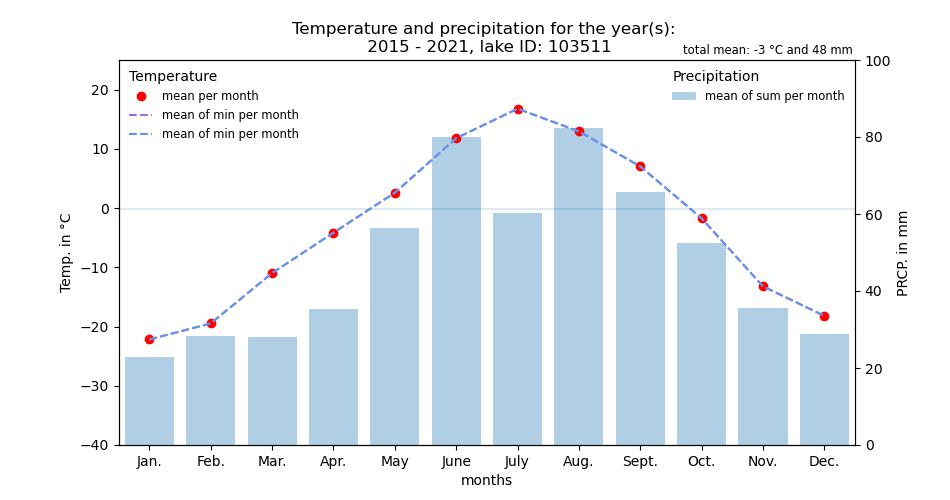

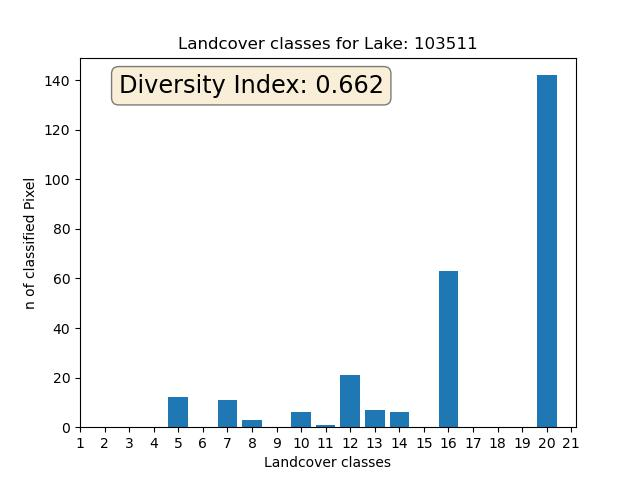

In [52]:
c = 0
filepaths = []
for folder in os.listdir('data\lake_data'):
    for file in os.listdir('data\lake_data\{}'.format(folder)):
        if 'landcover_classes_' in file and '.jpg' in file:
            filepaths.append('data\lake_data\{}\{}'.format(folder, file)) 
            c = c +1
        if 'climate_data_' in file and '.jpg' in file:
            filepaths.append('data\lake_data\{}\{}'.format(folder, file))
            c = c +1
        if c == 2:
            break
    if c == 2:
        break

print('selected RESULTS:')
print('...for Lake:', folder,'generated plots:')
for file in filepaths:
    display(Image(filename=file))

### Visualisation of the genereated data in the the CVL3D viewer
<em> You need to run the notebook now on your local machine! Until 24.01.2023 it was not possible within the polartep environment</em>

- tutorial about CVL3D viewer: https://github.com/CryosphereVirtualLab/cvl-3d-viz <br>
   - <b>copy</b> the cvl folder from the tutorial <br>
   - <b>edit</b> the module_path according to your environment

In [5]:
module_path = 'C:\\Users\\XXXXXX\\Documents\\cvl_notebooks\\selected_distrubed_lakes_ecosystem_data\\'

if module_path not in sys.path:
    sys.path.append(module_path)# +"/cvl")

#from cvl import viz
sys.path

from cvl.viz import viz, VBO, Raster
import os
import sys
import traceback
import numpy as np
import math
import time
import io
from osgeo import osr
from osgeo import gdal

visualizer = viz()

print('done')

done


- starting the server:	
	- in terminal: <b>python cvl/server.py </b><br>
	- <b>openssl req -x509 -nodes -days 730 -newkey rsa:2048 -keyout key.pem -out cert.pem -config cvl/localhost-ssl.conf</b>
    - <em> <b>adjust</b> your browser: needs to trust the certificate! https://localhost:3193/trust</em> <br><br>
- and again:
    - <b>python cvl/server.py</b> (only now the server is started!)

- display the shapefiles:
        - open https://cvl.eo.esa.int/ 
        - browser issues: brave browser does NOT work, firefox works! (disable addons!)
    <br>
<em> - is the server running? - follow tutorial cvl-3d-viz -> till 24.01.2023 not possible in the polartep... only if you run the notebook on your local machine! </em>


In [6]:
import shapefile
path = 'data/lake_data'

print('...display the shapefiles @ 3d viewer:')
for folder in os.listdir(path):
    if 'ID' in folder: 
        for files in os.listdir(path + '/' + folder):
            if '.shp' in files:
                file_input = path + '/' + folder + '/' + files
                Lake_ID = files.split('_')[-1][0:-4]

                geojson_data = shapefile.Reader(file_input).__geo_interface__
                metadata = { "path" : "shape_files", "geojson" : geojson_data }
                visualizer.publish_geojson('Lake: {}'.format(Lake_ID), metadata)
print('...done')    

...display the shapefiles @ 3d viewer:
...done


The shapefiles of the lakes are now visible in the CVL3D as shown below:
![](screenshot_1.PNG)


- gen_index function:                                <em>(1 to 1 from cvl-3d-viz-master/notebooks/Examples)</em><br>
    This function generates an index buffer rendering triangles. <br>
    It assumes that the vertices are laid out as in a regular grid. <br>
    Input parameters are the width and height of the grid.

In [10]:
def gen_index(width, height):
    verts_per_line = 2*width
    tris_per_line = verts_per_line-2
    num_tris = tris_per_line*(height-1)
    num_index = num_tris*3
    indices = np.zeros((num_index), dtype=np.uint32)
    idx = 0
    for y in range(0, height-1):
        for x in range(0, width-1):
            indices[idx+0]	= ((y+1) * width) + x
            indices[idx+1]	= (y*width)+x
            indices[idx+2]	= (y*width)+x+1
            indices[idx+3]	= (y*width)+x+1
            indices[idx+4]	= ((y+1) * width) + x+1
            indices[idx+5]	= ((y+1) * width) + x
            idx += 6
    return indices

- read the coordingates from the shapefile and display the data at the CVL3D:


In [12]:
import geopandas 
from pyproj import Proj

#__________________________________________________________________________
#display the available landcover and Era5 climate data 
def display_data(image_path, image_type):
    if 'Landcover' in image_type:
        image_origin = np.array([((origin[0])+250),((origin[1])+0),0])
    if 'Climate Data' in image_type:
        image_origin = np.array([((origin[0])+250),((origin[1])+700),0])

    texcoords = np.zeros((4, 2), dtype=np.float32)
    texcoords[0] = [0, 0]
    texcoords[1] = [1, 0]
    texcoords[2] = [0, 1]
    texcoords[3] = [1, 1]
    index = gen_index(2,2)

    with open(image_path, "rb") as fd:
        texture = fd.read()

    #reposition of the plot
    points = np.zeros((9,3), dtype=np.float64)
    for y in range(0,3):
        for x in range(0,3):
            points[y*3+x] = image_origin+[500*x, 300*-y, 0]

    raster = Raster(np.array(points[:, 0:2]), [3,3], 32633, image_data=texture)
    metadata = { "path" : "plots" }
    visualizer.publish_raster('{}: {}'.format(Lake_ID, image_type), metadata, raster)


    
#__________________________________________________________________________      

#umrechnen!?:
# gdf = geopandas.GeoDataFrame(df, geometry=gs, crs="EPSG:4326")
myProj = Proj("+proj=utm +zone=33 +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

#('...display the landcover plots and the era5 data  @ 3d viewer:')
for folder in os.listdir(path):
    if 'ID' in folder: 
        for files in os.listdir(path + '/' + folder):
            if '.shp' in files:
                file_input = path + '/' + folder + '/' + files
                Lake_ID = files.split('_')[-1][0:-4]
                
                ds = geopandas.read_file(file_input)
                ori = myProj(float(ds.bounds.maxx), float(ds.bounds.maxy))
                origin = np.array([list(ori)[0],list(ori)[1],0])
                
                for file in os.listdir(path + '/' + folder):
                    if '.jpg'in file and 'landcover' in file:
                        image_path = path + '/' + folder + '/' + file
                        image_type = 'Landcover'
                        display_data(image_path, image_type)
                    if '.jpg'in file and 'climate_data' in file:
                        image_path = path + '/' + folder + '/' + file
                        image_type = 'Climate Data'
                        display_data(image_path, image_type)

print('...done')     


...done


The <em>Landcover</em> and available <em>"Climate Data"</em> of the lakes are now added in the CVL3D as shown below:
![](screenshot_02.PNG)

- expected output: <em>see screenshots below</em>
<br>zoom in to one lake: 
![](screenshot_04.PNG)
<br>zoom in to another lake:
![](screenshot_5.PNG)

- important: <br>
    - in the <em> "Background Layer" </em>section: <em> "Vector Layer" </em>needs to be <b>enabled!</b> <em> Screenshot below, otherwise the <b>!whole!</b> data is not visible! </em> <br>
    - the image <b>tilt</b> need to be investigated...
![](screenshot_03.PNG)

The dataset is now visible at the Cryosphere Virtual Laboratory 3D Viewer, providing visualization and navigation of the georeferenced data. This includes the calculated indices, the pressure and temperature data and the different landcover classes for the selected lake areas. 

The changing cryosphere focusing on disturbed lakes can be described with the produced data. This includes ecosystem data (landcover classes) and lake area change (trend data). 

<em>The processing was done in this notebook by combining and editing multi-source data sets within the CVL environment.</em>